# Case 3. Patient Drug Review
**Neural Networks for Machine Learning Applications**<br>
12.03.2023<br>

Mateusz Czarnecki

Amal Kayed

Julian Marco Soliveres
<br>

[Information Technology, Bachelor's Degree](https://www.metropolia.fi/en/academics/bachelors-degrees/information-technology)<br>
[Metropolia University of Applied Sciences](https://www.metropolia.fi/en)

## 1. Introduction

In the following notebook, we are going to build a classification neural network model for a collection of patient drug reviews. Our main goal is to classify the review into "negative", "neutral" and "positive" classes based on the text review itself. For this purpose, we are going to experiment with recurrent and convolutional networks as well as with a basic Dense neural network model. 

## 2. Setup

To examine the problem, we are going to use a few important python libraries.
The libraries **pandas** and **numpy** are going to be used to perform mathematical operations on data and group it into DataFrames.

The **matplotlib** library will be used to create the plots and e.g visualize the model performance.

The library **tensorflow.keras** is going the help us a lot with creating, compiling and training and validating the network model.

**nltk** library will be responsible for providing text-analytics related functions

We'll use **bs4** to format the HTML into basic txt format

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Activation, Bidirectional, BatchNormalization, Dropout
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras import preprocessing

from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from bs4 import BeautifulSoup

from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

import re

## 3. Dataset

The dataset is a collection of patient drugs reviews extracted from Drugs.com. It consists of two csv files representing training and testing set. Both sets consist of 215 062 reviews in total.

In [68]:
train = pd.read_csv('/kaggle/input/kuc-hackathon-winter-2018/drugsComTrain_raw.csv')
test = pd.read_csv('/kaggle/input/kuc-hackathon-winter-2018/drugsComTest_raw.csv')

In [123]:
train.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",1,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",1,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",2,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",1,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",1,27-Nov-16,37


In [126]:
test.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,163740,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over th...",1,28-Feb-12,22
1,206473,Mesalamine,"Crohn's Disease, Maintenance","""My son has Crohn&#039;s disease and has done ...",1,17-May-09,17
2,159672,Bactrim,Urinary Tract Infection,"""Quick reduction of symptoms""",1,29-Sep-17,3
3,39293,Contrave,Weight Loss,"""Contrave combines drugs that were used for al...",1,5-Mar-17,35
4,97768,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cyc...",1,22-Oct-15,4


In [70]:
train.shape

(161297, 7)

In [125]:
test.shape

(53766, 7)

## 4. Preprocessing

Before creating a model, we have to preprocess our text data in order to give us as much information as it can. To analyze the data properly, we are firstly going to display the count of rows based on their rating. 

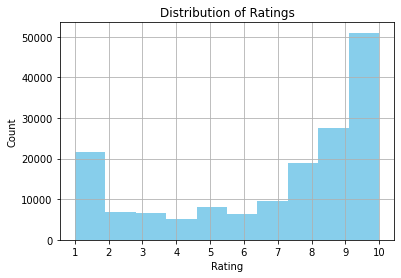

In [71]:
train.rating.hist(color='skyblue')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.xticks([i for i in range(1, 11)]);

Now, we are going to change extract the ratings into three categories:

- negative (rating <5)
- neutral  (rating 5-6)
- negative (rating >6)

By such an extraction, from now we can operate only on those 3 categories and don't try to predict the exact rating.

In [72]:
train['rating'] = train["rating"].apply(lambda x: 1 if x >= 8 else 2 if x >= 5 else 0)
test['rating'] = test["rating"].apply(lambda x: 1 if x >= 8 else 2 if x >= 5 else 0)

In [45]:
train.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",1,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",1,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",2,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",1,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",1,27-Nov-16,37


In [46]:
test.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,163740,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over th...",1,28-Feb-12,22
1,206473,Mesalamine,"Crohn's Disease, Maintenance","""My son has Crohn&#039;s disease and has done ...",1,17-May-09,17
2,159672,Bactrim,Urinary Tract Infection,"""Quick reduction of symptoms""",1,29-Sep-17,3
3,39293,Contrave,Weight Loss,"""Contrave combines drugs that were used for al...",1,5-Mar-17,35
4,97768,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cyc...",1,22-Oct-15,4


We divide the dataset into for subsets:
- train_x - input data for training
- train_y - output labels for training
- test_x  - input data for testing
- test_y  - output labels for teting

In [74]:
train_x = train['review'].values.tolist()
train_y = train['rating'].values
test_x = test['review'].values.tolist()
test_y = test['rating'].values

After separating the data into subsets, we are going to tokenize the text masses and create the sequences out of them. This preprocessing step is going to create the corresponding integer lists after tokenization.

In [76]:
tokenizer = Tokenizer(num_words = 5000)
tokenizer.fit_on_texts(train_x)

train_sequences = tokenizer.texts_to_sequences(train_x)
test_sequences = tokenizer.texts_to_sequences(test_x)

print("Train sequences:")
print(train_sequences[0])

maxlen = 100
train_sequences = preprocessing.sequence.pad_sequences(train_sequences, maxlen = maxlen)
test_sequences = preprocessing.sequence.pad_sequences(test_sequences, maxlen = maxlen)

print("\nTrain sequences after padding:")
print(train_sequences[0])

Train sequences:
[5, 38, 28, 35, 197, 1, 45, 5, 15, 848, 12, 2922, 99, 150, 2, 3806, 1551]

Train sequences after padding:
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    5
   38   28   35  197    1   45    5   15  848   12 2922   99  150    2
 3806 1551]


Next, we change the labels (ratings) into categorical values using One-Hot Encoding. We simply change the numerical representation into tables of binary values, which makes it easy for the network to recognize as separate categories.

In [77]:
print("Labels before one hot encoding:")
print(train_y[161292:])

train_y = to_categorical(train_y)
test_y = to_categorical(test_y)

print("\nAfter one hot encoding:")
print(train_y[161292:])

Labels before one hot encoding:
[1 0 0 1 1]

After one hot encoding:
[[0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]


## 5. Modeling

We create a LSTM sequence model using an Embedding, Dropout, Batch Normalization and Dense layers. After checking the performance, this is the model we ended up with the following model:

In [99]:
rnn_model = Sequential()
rnn_model.add(Embedding(5000, 16, input_length = maxlen))
rnn_model.add(Bidirectional(LSTM(16,dropout=0.2, recurrent_dropout=0.2)))
rnn_model.add(Dense(256, activation='sigmoid'))
rnn_model.add(Dropout(0.5))
rnn_model.add(BatchNormalization())
rnn_model.add(Dense(3, activation = 'softmax')) 

rnn_model.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['acc']) 
rnn_model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 100, 16)           80000     
_________________________________________________________________
bidirectional_9 (Bidirection (None, 32)                4224      
_________________________________________________________________
dense_17 (Dense)             (None, 256)               8448      
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 256)               1024      
_________________________________________________________________
dense_18 (Dense)             (None, 3)                 771       
Total params: 94,467
Trainable params: 93,955
Non-trainable params: 512
_______________________________________________

To make our explorations of the problem even deeper, we decided to also create a convolutional 1D model using the Conv1D layers. As well as the previous model, it is using reLu as an activation function, rmsprop optimizer and categorical crossentropy loss function. Despite the Convolutional layers, the model uses MaxPoolling and Embedding Layers as well.

In [85]:
conv_model = Sequential()
conv_model.add(Embedding(5000, 8, input_length = 100))
conv_model.add(Conv1D(32, 5, activation='relu'))
conv_model.add(MaxPooling1D(3))
conv_model.add(Conv1D(32, 5, activation='relu'))
conv_model.add(GlobalMaxPooling1D())
conv_model.add(Dense(3, activation='softmax'))

conv_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])
conv_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 100, 8)            40000     
_________________________________________________________________
conv1d (Conv1D)              (None, 96, 32)            1312      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 32, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 28, 32)            5152      
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 3)                 99        
Total params: 46,563
Trainable params: 46,563
Non-trainable params: 0
__________________________________________________

## 6. Training

The training proccess occured to be the biggest challange of the given task, because of time consuming process of training the models. To make the process more efficient, we decided on setting a high batch size as a hyperparameter. This operation significantly lowered the computation time, but training the models on a larger amount of epochs seemed to be still too time consuming for us.

Therefore, we trained our models on 10 epochs and try to predict the performance based on that.

In [103]:
rnn_history = rnn_model.fit(train_sequences, train_y, 
                    epochs = 10,
                    batch_size = 2500,
                    validation_split = 0.2)

Epoch 1/10
52/52 [==============================] - 127s 2s/step - loss: 1.1337 - acc: 0.5063 - val_loss: 0.8181 - val_acc: 0.7141
Epoch 2/10
52/52 [==============================] - 103s 2s/step - loss: 0.7869 - acc: 0.6900 - val_loss: 0.7204 - val_acc: 0.7218
Epoch 3/10
52/52 [==============================] - 103s 2s/step - loss: 0.6953 - acc: 0.7329 - val_loss: 0.6681 - val_acc: 0.7410
Epoch 4/10
52/52 [==============================] - 93s 2s/step - loss: 0.6645 - acc: 0.7430 - val_loss: 0.6644 - val_acc: 0.7389
Epoch 5/10
52/52 [==============================] - 87s 2s/step - loss: 0.6497 - acc: 0.7474 - val_loss: 0.6515 - val_acc: 0.7431
Epoch 6/10
52/52 [==============================] - 85s 2s/step - loss: 0.6389 - acc: 0.7497 - val_loss: 0.6504 - val_acc: 0.7419
Epoch 7/10
52/52 [==============================] - 91s 2s/step - loss: 0.6272 - acc: 0.7523 - val_loss: 0.6358 - val_acc: 0.7464
Epoch 8/10
52/52 [==============================] - 93s 2s/step - loss: 0.6179 - acc: 0

In [86]:
conv_history = conv_model.fit(train_sequences, 
                              train_y, 
                              epochs=10, 
                              batch_size=64, 
                              validation_split=0.2)

Epoch 1/10
2017/2017 [==============================] - 19s 9ms/step - loss: 0.7376 - acc: 0.6990 - val_loss: 0.6681 - val_acc: 0.7319
Epoch 2/10
2017/2017 [==============================] - 18s 9ms/step - loss: 0.6312 - acc: 0.7479 - val_loss: 0.6452 - val_acc: 0.7401
Epoch 3/10
2017/2017 [==============================] - 18s 9ms/step - loss: 0.5867 - acc: 0.7642 - val_loss: 0.6062 - val_acc: 0.7566
Epoch 4/10
2017/2017 [==============================] - 18s 9ms/step - loss: 0.5613 - acc: 0.7750 - val_loss: 0.6183 - val_acc: 0.7574
Epoch 5/10
2017/2017 [==============================] - 17s 9ms/step - loss: 0.5415 - acc: 0.7835 - val_loss: 0.6274 - val_acc: 0.7470
Epoch 6/10
2017/2017 [==============================] - 19s 10ms/step - loss: 0.5257 - acc: 0.7909 - val_loss: 0.6107 - val_acc: 0.7514
Epoch 7/10
2017/2017 [==============================] - 19s 9ms/step - loss: 0.5118 - acc: 0.7968 - val_loss: 0.6409 - val_acc: 0.7469
Epoch 8/10
2017/2017 [==============================] 

## 7. Performance and evaluation

On the plots, we can see the accuracy on epoch number change. As we can see, the accuracy varies around 75% in both models

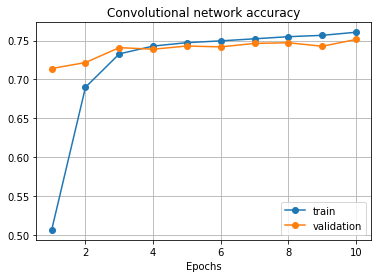

In [110]:
acc = rnn_history.history['acc']
val_acc = rnn_history.history['val_acc']
loss = rnn_history.history['loss']
val_loss = rnn_history.history['val_loss']

plt.plot(e, acc, 'o-', label='train')
plt.plot(e, val_acc, 'o-', label='validation')
plt.title('Convolutional network accuracy')
plt.xlabel('Epochs')
plt.grid()
plt.legend()

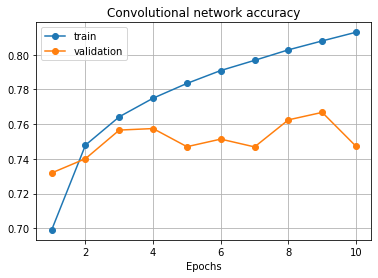

In [109]:
acc = conv_history.history['acc']
val_acc = conv_history.history['val_acc']
loss = conv_history.history['loss']
val_loss = conv_history.history['val_loss']

plt.plot(e, acc, 'o-', label='train')
plt.plot(e, val_acc, 'o-', label='validation')
plt.title('Convolutional network accuracy')
plt.xlabel('Epochs')
plt.grid()
plt.legend()

We are now going to evaluate the models using the test set.

In [112]:
rnn_results = rnn_model.evaluate(test_sequences, test_y)
conv_results = conv_model.evaluate(test_sequences, test_y)


1681/1681 [==============================] - 5s 3ms/step - loss: 0.6438 - acc: 0.7502


Here is the final performance evaluation for both models. As we can see, both model reach around 75% accuracy and around 0,6 loss function indicator.

In [120]:
print()
print('----------------------------------')
print('Summary performance indicators:')
print('----------------------------------')

print('\n\n----------------------------------')
print('LSTM Model:')
print('----------------------------------')
print('Loss function: ', rnn_results[0])
print('Accuracy: ', rnn_results[1])
      
print('\n\n----------------------------------')
print('Convolutional Model:')
print('----------------------------------')    
print('Loss function: ', conv_results[0])
print('Accuracy: ', conv_results[1])
                               
                               


----------------------------------
Summary performance indicators:
----------------------------------


----------------------------------
LSTM Model:
----------------------------------
Loss function:  0.6205968856811523
Accuracy:  0.7528921365737915


----------------------------------
Convolutional Model:
----------------------------------
Loss function:  0.6438040137290955
Accuracy:  0.7501952648162842


## 8. Discussion and conclusions

To sum up our work on the Patient Drug Review classification, we created two models predicting the reviews. Both of those models reached similar accuracy of 75%, which we believe, for the given dataset is a fairly reasonable result.

Our final LSTM model consists of: Embedding Layer, LSTM layer, Dense layers with 256 and 3 neurons, a dropout layer to reduce the overfitting tendency and a batch normalization layer.

The final convolutional network consists of: Embedding Layer, Convolutional layers, Max Pooling layers and a Dense layer outputting the final results with a softmax activation function.

Our main observation is that a well preprocessed text data is a key to achieve an accurate predicting model.

The main challange we faced was a long network computing time. Finally, we decided to simplify our models, enlarge the batch sizes and lower the number of batches in order to reduce it.

We found the task really interesting and as a great way to get familiar with the text-analytics machine learning tools.